## Introdução

O projeto Guard.IAn é um sistema de inteligência artificial voltado à detecção de violência em vídeos e imagens. Utilizando redes neurais convolucionais (CNNs) e técnicas de deep learning, o sistema analisará cenas capturadas por câmeras de segurança para identificar comportamentos agressivos, como brigas e ataques físicos, distinguindo-os de interações normais com maior precisão e menos alarmes falsos.

Para isso, serão empregados modelos pré-treinados, como a VGG-16, que atuarão como extratores de características visuais dos frames. A partir de bases de dados rotuladas com cenas violentas e não violentas, o Guard.IAn será treinado e ajustado para reconhecer padrões agressivos, com potencial de integração futura a plataformas de monitoramento e emissão de alertas automáticos em tempo real.


## Código

### Importação de Bibliotecas

In [ ]:
%matplotlib inline

# Bibliotecas padrão do Python
import collections
import os
import random
import sys

# Bibliotecas de terceiros (instaladas via pip)
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Activation, Dense, Dropout, GlobalAveragePooling2D,
                                     Input, LSTM)
from tensorflow.keras.models import Model, Sequential


# RETIRAR A PARTE DO COLAB QUANDO FOR DAR UPLOAD PRO GITHUB E MONTAR OS CAMINHHOS COM O TRECHO ABAIXO:

#base_videos_folder = './videos'
#violence_path = os.path.join(base_videos_folder, 'violence')
#nonviolence_path = os.path.join(base_videos_folder, 'nonviolence')
#test_videos_path = os.path.join(base_videos_folder, 'test_videos')

### Extração de Frames

In [ ]:
def extract_frames(video_path, max_frames=40):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while True:
        ret, frame = cap.read()
        if not ret or count >= max_frames:
            break
        frame = cv2.resize(frame, (224, 224))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        count += 1

    cap.release()

    # Converte para array numpy
    frames = np.array(frames)

    # Se o vídeo tiver menos de max_frames, preenche com zeros
    if len(frames) < max_frames:
        pad_length = max_frames - len(frames)
        padding = np.zeros((pad_length, 224, 224, 3), dtype=np.uint8)
        frames = np.concatenate((frames, padding), axis=0)

    return frames

### Categorizando vídeos

In [ ]:
def load_videos_from_folder(folder_path, label, max_frames=40):
    data = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4') or filename.endswith('.avi'):
            video_path = os.path.join(folder_path, filename)
            frames = extract_frames(video_path, max_frames)
            if len(frames) == max_frames:
                data.append(frames)
                labels.append(label)

    return data, labels

from google.colab import drive
drive.mount('/content/drive')

# Caminhos
violence_path = '/content/drive/MyDrive/Colab Notebooks/GuardIAn/videos/violence'
nonviolence_path = '/content/drive/MyDrive/Colab Notebooks/GuardIAn/videos/nonviolence'

# Carrega vídeos
violence_data, violence_labels = load_videos_from_folder(violence_path, label=1)
nonviolence_data, nonviolence_labels = load_videos_from_folder(nonviolence_path, label=0)

# Junta tudo
X = np.array(violence_data + nonviolence_data)
y = np.array(violence_labels + nonviolence_labels)

# Embaralha os dados
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)


Mounted at /content/drive


### Extração de Características com VGG-16

In [ ]:
# Carrega o modelo VGG16 pré-treinado no ImageNet, excluindo as camadas do topo
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Input para o extrator de características
feature_extractor_input = Input(shape=(224, 224, 3))

# Conecta o VGG16 ao input
x = vgg16_model(feature_extractor_input)

# Adiciona uma camada de Global Average Pooling 2D
feature_extractor_output = GlobalAveragePooling2D()(x)a

# Cria o modelo extrator de características
feature_extractor_model = Model(inputs=feature_extractor_input, outputs=feature_extractor_output)

print("Resumo do Modelo Extrator de Características (VGG16 com GlobalAveragePooling):")
feature_extractor_model.summary()

print("\nIniciando a extração de características de vídeo...")
extracted_features = []
for i, video_frames in enumerate(X):
    video_features = []
    for frame in video_frames:
        frame_features = feature_extractor_model.predict(np.expand_dims(frame, axis=0), verbose=0)[0]
        video_features.append(frame_features)
    extracted_features.append(video_features)
    if (i + 1) % 10 == 0:
        print(f"Extração de características concluída para {i + 1}/{len(X)} vídeos.")

extracted_features = np.array(extracted_features)

print(f"\nExtração de características concluída. Formato final: {extracted_features.shape}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Resumo do Modelo Extrator de Características (VGG16 com GlobalAveragePooling):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando a extração de características de vídeo...
Extração de características concluída para 10/503 vídeos.
Extração de características concluída para 20/503 vídeos.
Extração de características concluída para 30/503 vídeos.
Extração de características concluída para 40/503 vídeos.
Extração de características concluída para 50/503 vídeos.
Extração de características concluída para 60/503 vídeos.
Extração de características concluída para 70/503 vídeos.
Extração de características concluída para 80/503 vídeos.
Extração de características concluída para 90/503 vídeos.
Extração de características concluída para 100/503 vídeos.
Extração de características concluída para 110/503 vídeos.
Extração de características concluída para 120/503 vídeos.
Extração de características concluída para 130/503 vídeos.
Extração de características concluída para 140/503 vídeos.
Extração de características concluída para 150/503 vídeos.
Extração de características concluída para 160/503 vídeos.
Extração de 

### Construção de modelo LTSM

In [ ]:
# Definir as dimensões de entrada para o modelo LSTM
MAX_FRAMES = extracted_features.shape[1]
FEATURE_DIM = extracted_features.shape[2]

print(f"Dimensões de entrada para o LSTM: (max_frames={MAX_FRAMES}, feature_dimension={FEATURE_DIM})")

# Construção do Modelo Sequencial
model = Sequential()

model.add(LSTM(units=256, return_sequences=True, input_shape=(MAX_FRAMES, FEATURE_DIM)))
model.add(Dropout(0.6))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.6))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(units=1, activation='sigmoid'))

# Compilação do Modelo
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Exibe o resumo do modelo
print("\nResumo do Modelo LSTM:")
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                # Para o treino se não houver melhora por 5 épocas
    restore_best_weights=True
)

Dimensões de entrada para o LSTM: (max_frames=40, feature_dimension=512)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Resumo do Modelo LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,745 (3.33 MB)

 Trainable params: 871,745 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

### Treinamento do Modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    extracted_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_test: {y_test.shape}")

print("\nIniciando o treinamento do modelo...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

print("\nTreinamento concluído!")

Shape de X_train: (402, 40, 512)
Shape de y_train: (402,)
Shape de X_test: (101, 40, 512)
Shape de y_test: (101,)

Iniciando o treinamento do modelo...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.6338 - loss: 0.6430 - val_accuracy: 0.8218 - val_loss: 0.4203
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8121 - loss: 0.4461 - val_accuracy: 0.8614 - val_loss: 0.3062
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8519 - loss: 0.3974 - val_accuracy: 0.9010 - val_loss: 0.2496
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8865 - loss: 0.2825 - val_accuracy: 0.9604 - val_loss: 0.1692
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9194 - loss: 0.2310 - val_accuracy: 0.9703 - val_loss: 0.1078
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9076 - loss: 0.2225 - val_accuracy: 0.9406 - val_loss: 0.1436
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9609 - loss: 0.1394 -

### Avaliação do Modelo

Acurácia do modelo no conjunto de teste: 0.9703
Perda do modelo no conjunto de teste: 0.1078

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.98      0.99      0.98        81

    accuracy                           0.97       101
   macro avg       0.96      0.94      0.95       101
weighted avg       0.97      0.97      0.97       101


Matriz de Confusão:
[[18  2]
 [ 1 80]]

Visualizando o Histórico de Treinamento...


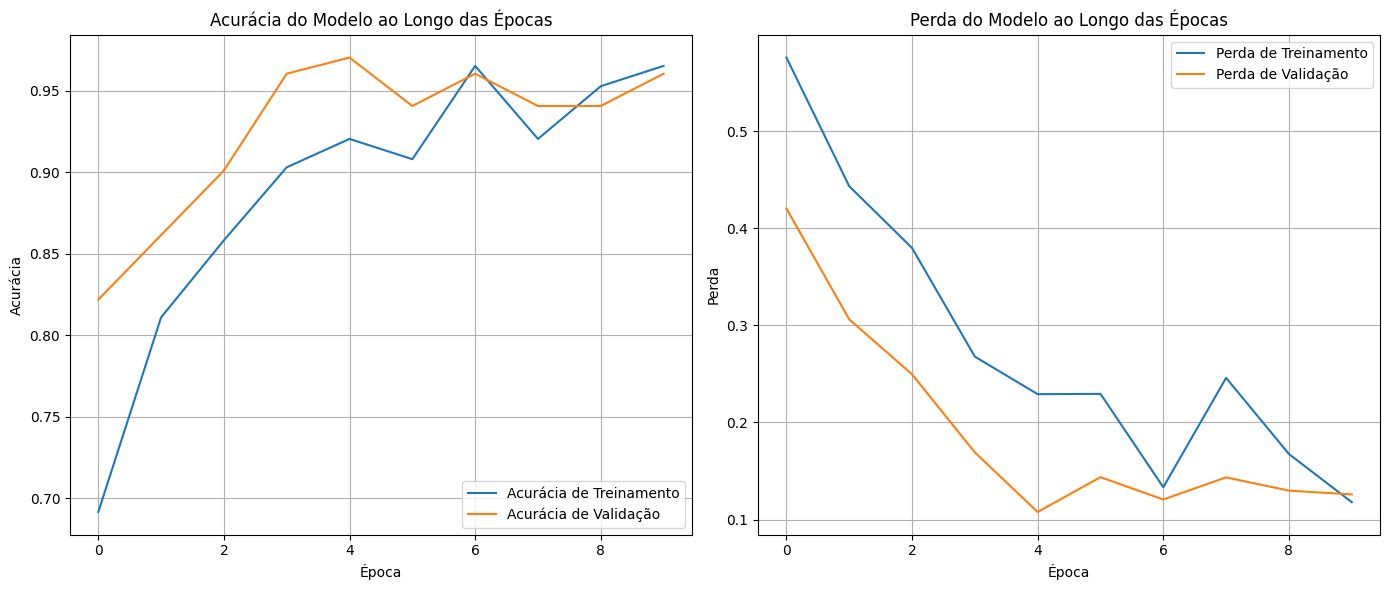

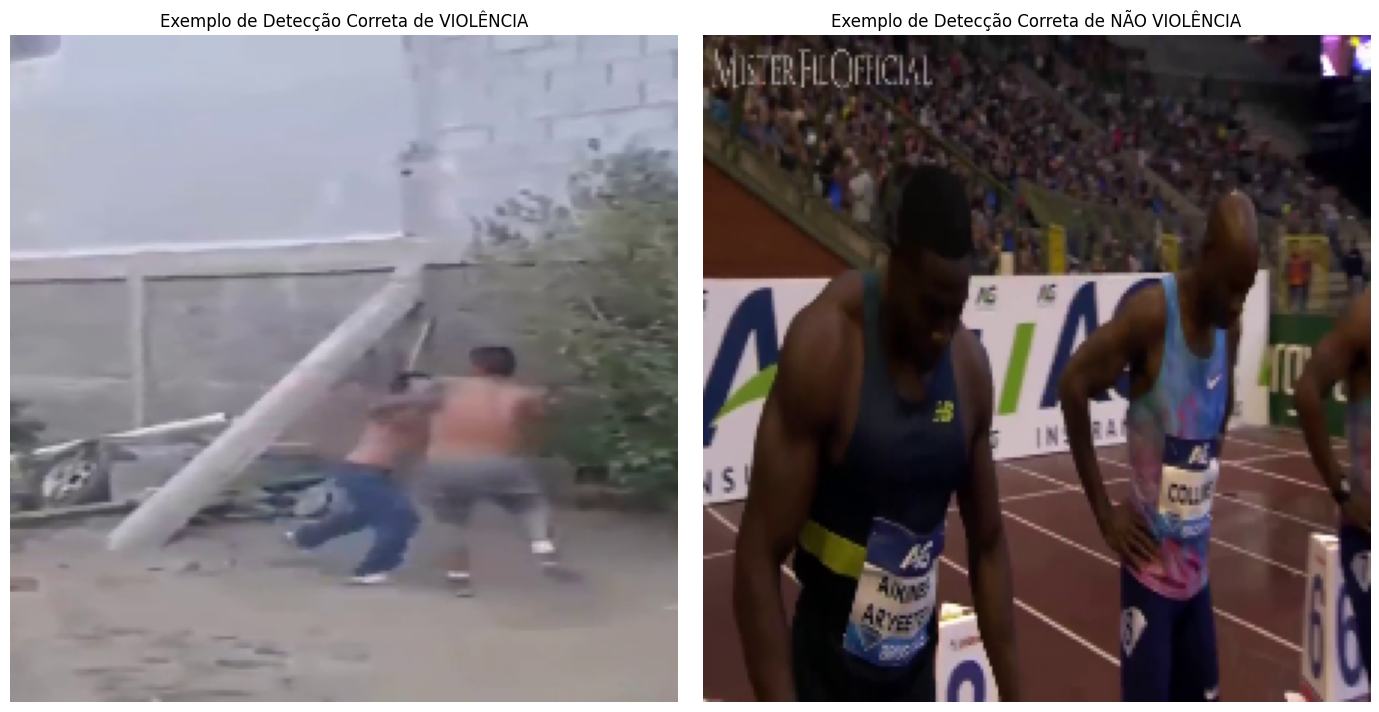

In [ ]:
# --------------------------------------------------------------------
# 1. DIVISÃO DOS DADOS (APENAS PARA OBTER OS CONJUNTOS DE TESTE)
# --------------------------------------------------------------------
# Divide as CARACTERÍSTICAS para o teste
_, X_test, _, y_test = train_test_split(
    extracted_features, y, test_size=0.2, random_state=42, stratify=y
)

# Divide os PIXELS originais para podermos exibir os frames depois
_, X_test_pixels, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# --------------------------------------------------------------------
# 2. AVALIAÇÃO DO MODELO E RELATÓRIOS
# --------------------------------------------------------------------
# Avalia o modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia do modelo no conjunto de teste: {accuracy:.4f}")
print(f"Perda do modelo no conjunto de teste: {loss:.4f}")

# Faz previsões no conjunto de teste
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Imprime o Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Imprime a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


# --------------------------------------------------------------------
# 3. PLOT DOS GRÁFICOS DE TREINAMENTO
# --------------------------------------------------------------------
print("\nVisualizando o Histórico de Treinamento...")
plt.figure(figsize=(14, 6))

# Plot da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Plot da Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 4. EXIBIÇÃO DOS FRAMES DE EXEMPLO
# --------------------------------------------------------------------

# Encontrar um exemplo de VIOLÊNCIA detectado corretamente (Verdadeiro Positivo)
tp_indices = np.where((y_test == 1) & (y_pred.flatten() == 1))[0]
# Encontrar um exemplo de NÃO VIOLÊNCIA detectado corretamente (Verdadeiro Negativo)
tn_indices = np.where((y_test == 0) & (y_pred.flatten() == 0))[0]

# Cria uma nova figura para exibir os dois frames lado a lado
plt.figure(figsize=(14, 7))

# Exibe o frame de VIOLÊNCIA
if len(tp_indices) > 0:
    idx = np.random.choice(tp_indices)
    frame_violento = X_test_pixels[idx][20] # Pega um frame do meio do vídeo

    plt.subplot(1, 2, 1)
    plt.imshow(frame_violento)
    plt.title('Exemplo de Detecção Correta de VIOLÊNCIA')
    plt.axis('off')

# Exibe o frame de NÃO VIOLÊNCIA
if len(tn_indices) > 0:
    idx = np.random.choice(tn_indices)
    frame_nao_violento = X_test_pixels[idx][20] # Pega um frame do meio do vídeo

    plt.subplot(1, 2, 2)
    plt.imshow(frame_nao_violento)
    plt.title('Exemplo de Detecção Correta de NÃO VIOLÊNCIA')
    plt.axis('off')

# Mostra os plots apenas se encontrou exemplos
if len(tp_indices) > 0 or len(tn_indices) > 0:
    plt.tight_layout()
    plt.show()

### Criação de Janela Deslizante Para Análise Inteiriça do Vídeo

In [ ]:
def analisar_video_com_janela_deslizante(video_path, feature_extractor, lstm_classifier,
                                           window_size=40, step=10, confidence_threshold=0.80):
    """
    Analisa um vídeo usando uma janela deslizante para detectar violência.
    """
    print(f"\n--- Iniciando Análise Contínua do Vídeo: {os.path.basename(video_path)} ---")

    try:
        video_stream = cv2.VideoCapture(video_path)
        if not video_stream.isOpened():
            print("Erro ao abrir o arquivo de vídeo.")
            return

        fps = video_stream.get(cv2.CAP_PROP_FPS)
        frames_deque = collections.deque(maxlen=window_size)
        frame_count = 0
        violence_detected = False

        while True:
            ret, frame = video_stream.read()
            if not ret:
                break

            frame_count += 1
            frame_resized = cv2.resize(frame, (224, 224))
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
            frames_deque.append(frame_rgb)

            if len(frames_deque) == window_size and (frame_count % step) == 0:
                features_para_predicao = []
                for f in list(frames_deque):
                    frame_features = feature_extractor.predict(np.expand_dims(f, axis=0), verbose=0)[0]
                    features_para_predicao.append(frame_features)

                processed_video_features = np.array(features_para_predicao)
                processed_video_features = np.expand_dims(processed_video_features, axis=0)
                prediction_proba = lstm_classifier.predict(processed_video_features, verbose=0)[0][0]

                if prediction_proba > confidence_threshold:
                    timestamp = frame_count / fps
                    print(f"\n>>> ALERTA: Violência detectada em {timestamp:.2f} segundos! <<<")
                    print(f"    (Probabilidade: {prediction_proba:.2f})")
                    violence_detected = True
                    break

        if not violence_detected:
            print("\n--- Análise concluída. Nenhuma violência detectada. ---")

    finally:
        if 'video_stream' in locals() and video_stream.isOpened():
            video_stream.release()

### Testes com vídeos aleatórios foras do dataset

Buscando vídeos na pasta: /content/drive/MyDrive/Colab Notebooks/GuardIAn/videos/test_videos

--- Iniciando Análise Contínua do Vídeo: V_164.mp4 ---

>>> ALERTA: Violência detectada em 2.25 segundos! <<<
    (Probabilidade: 0.99)

Frame que acionou o alerta:


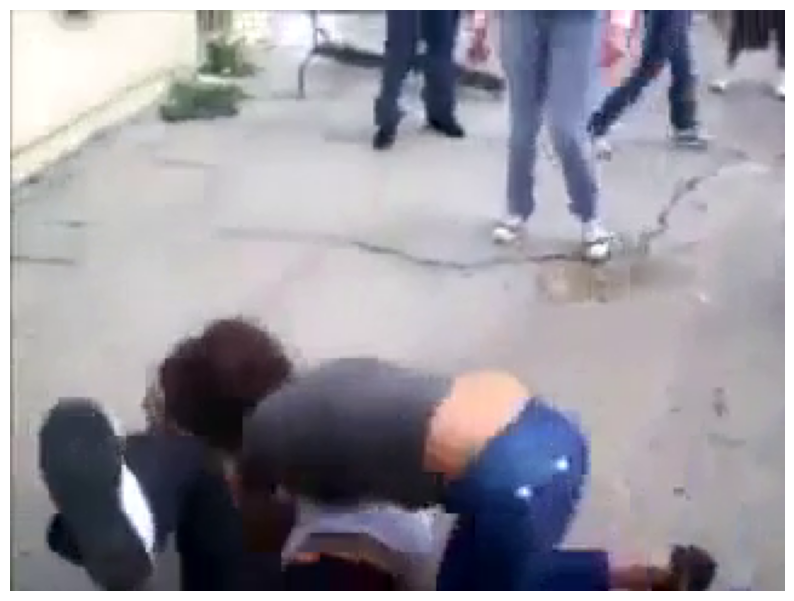

In [ ]:
# ---------------------------------------------------------------------------
# 1. DEFINIÇÃO DA FUNÇÃO DE ANÁLISE
# ---------------------------------------------------------------------------
def analisar_video_com_janela_deslizante(video_path, feature_extractor, lstm_classifier,
                                           window_size=40, step=10, confidence_threshold=0.80):
    """
    Analisa um vídeo usando uma janela deslizante e exibe o frame em caso de detecção,
    ou um frame aleatório se nada for encontrado.
    """

    print(f"\n--- Iniciando Análise Contínua do Vídeo: {os.path.basename(video_path)} ---")

    try:
        video_stream = cv2.VideoCapture(video_path)
        if not video_stream.isOpened():
            print("Erro ao abrir o arquivo de vídeo.")
            return

        fps = video_stream.get(cv2.CAP_PROP_FPS)
        total_frames = int(video_stream.get(cv2.CAP_PROP_FRAME_COUNT))

        frames_deque = collections.deque(maxlen=window_size)
        frame_count = 0
        violence_detected = False

        while True:
            ret, frame = video_stream.read()
            if not ret:
                break

            frame_count += 1

            frame_resized = cv2.resize(frame, (224, 224))
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
            frames_deque.append(frame_rgb)

            if len(frames_deque) == window_size and (frame_count % step) == 0:
                features_para_predicao = []
                for f in list(frames_deque):
                    frame_features = feature_extractor.predict(np.expand_dims(f, axis=0), verbose=0)[0]
                    features_para_predicao.append(frame_features)

                processed_video_features = np.array(features_para_predicao)
                processed_video_features = np.expand_dims(processed_video_features, axis=0)
                prediction_proba = lstm_classifier.predict(processed_video_features, verbose=0)[0][0]

                if prediction_proba > confidence_threshold:
                    timestamp = frame_count / fps
                    print(f"\n>>> ALERTA: Violência detectada em {timestamp:.2f} segundos! <<<")
                    print(f"    (Probabilidade: {prediction_proba:.2f})")

                    print("\nFrame que acionou o alerta:")
                    frame_display = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(10, 8))
                    plt.imshow(frame_display)
                    plt.axis('off')
                    plt.show()

                    violence_detected = True
                    break

        if not violence_detected:
            print("\n--- Análise concluída. Nenhuma violência detectada. ---")

            if total_frames > 0:
                random_frame_index = random.randint(0, total_frames - 1)
                # É necessário reabrir para pular para o frame, pois o stream já foi lido
                video_stream_rand = cv2.VideoCapture(video_path)
                if video_stream_rand.isOpened():
                    video_stream_rand.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
                    ret_rand, random_frame = video_stream_rand.read()

                    if ret_rand:
                        print(f"\nExibindo um frame aleatório (frame nº {random_frame_index}):")
                        frame_display = cv2.cvtColor(random_frame, cv2.COLOR_BGR2RGB)
                        plt.figure(figsize=(10, 8))
                        plt.imshow(frame_display)
                        plt.axis('off')
                        plt.show()
                    video_stream_rand.release()

    finally:
        if 'video_stream' in locals() and video_stream.isOpened():
            video_stream.release()

# ---------------------------------------------------------------------------
# 2. EXECUÇÃO DO TESTE
# ---------------------------------------------------------------------------

# Define o caminho para a pasta com vídeos de teste
test_videos_path = '/content/drive/MyDrive/Colab Notebooks/GuardIAn/videos/test_videos'
print(f"Buscando vídeos na pasta: {test_videos_path}")

# Lista todos os vídeos disponíveis na pasta
available_videos = [os.path.join(test_videos_path, f) for f in os.listdir(test_videos_path) if f.endswith(('.mp4', '.avi'))]

# Verifica se encontrou algum vídeo
if not available_videos:
    print("Nenhum vídeo encontrado na pasta de teste.")
else:
    # Escolhe um vídeo aleatoriamente para testar
    random_video_path = random.choice(available_videos)

    # Chama a função de análise contínua
    analisar_video_com_janela_deslizante(
        video_path=random_video_path,
        feature_extractor=feature_extractor_model,
        lstm_classifier=model,
        step=15,
        confidence_threshold=0.85
    )